In [ ]:
import math
import random
import skimage.io as io
import matplotlib.pyplot as plt
import keras
import pickle
import numpy as np
# import cv2
import os
from os import listdir
from os.path import isfile, join
import sys
# import dlib
# import skvideo.io
import json
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import glob
import re
from collections import defaultdict

import nltk
from nltk.corpus import cmudict
import tensorflow as tf
import wer

In [ ]:
!nvidia-smi

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
phoneme_list = [] 
phoneme_dict = {}

with open("/n/fs/scratch/jiaqis/cmudict-master/cmudict.phones", 'r') as fp:
    i = 0
    line = fp.readline()
    while line:
        phoneme = line.split()[0].strip()
        phoneme_property = line.split()[1].strip()
        phoneme_list.append((phoneme, phoneme_property))
        phoneme_dict[phoneme] = i+3
        line = fp.readline()
        i=i+1
        
phoneme_dict['START'] = 0
phoneme_dict["END"] = 1
phoneme_dict["UNK"] = 2
print(phoneme_list, phoneme_dict)

In [ ]:
pron_dict = cmudict.dict()

In [ ]:
DATA_DIR = "/n/fs/scratch/jiaqis/LRS3-TED/"
SAVE_DIR = "/n/fs/scratch/jiaqis/LRS3-TED-Extracted/"

In [ ]:
test_ID_list = json.load(open('test_ID_list.json', "r"))
trainval_ID_list = json.load(open('trainval_ID_list.json', "r"))

In [ ]:
import logging

import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers


GO_TOKEN = 0
END_TOKEN = 1
UNK_TOKEN = 2

In [ ]:
def clean_pron(pron):
    """Remove stress from pronunciations."""
    return re.sub(r"\d", "", pron)

def make_triphones(pron):
    """Output triphones from a word's pronunciation."""
    if len(pron) < 3:
        return []
    # Junk on end is to make word boundaries work
    return ([((pron[idx - 2], pron[idx - 1]), pron[idx])
             for idx in range(2, len(pron))] + [(('#', '#'), pron[0])] +
            [((pron[-2], pron[-1]), '#')])
                                                
def triphone_probs(prons):
    """Calculate triphone probabilities for pronunciations."""
    context_counts = defaultdict(lambda: defaultdict(int))
    for pron in prons:
        for (context, phoneme) in make_triphones(pron):
            context_counts[context][phoneme] += 1
            
    for (context, outcomes) in context_counts.items():
        total_outcomes = sum(outcomes.values())
        for outcome, count in outcomes.items():
            context_counts[context][outcome] = float(count) / total_outcomes
        
    return context_counts

In [ ]:
def prepare_data(filepath, img_size, keypoint_img_size, keypoint_size):
    # images
    # frames x rows x cols x channels
    visual_cube = []
    # keypoint features
    feature_cube = []
    features = json.load(open(filepath + ".json", 'r'))
    # Target Text/phonemes
    labels = []
    text = open(filepath+".txt", 'r').readline()
    words = text[5:].lower().strip().split()
    for word in words:
        word_phonemes = pron_dict[word][0]
        word_indices = [phoneme_dict[clean_pron(phon)] for phon in word_phonemes]
        labels.extend(word_indices)
        
    acc = 0
    for imgFilename in sorted(glob.glob(filepath + "_*_mouth.jpg")): # 
#         if 'mouth' in imgFilename: # 
#             continue               #
        x = image.img_to_array(
              image.load_img(imgFilename, target_size=img_size))/255.0
#         x = np.expand_dims(x, axis=0)
#         x = preprocess_input(x)
        visual_cube.append(x)
        
        mask = np.zeros((keypoint_img_size[0], keypoint_img_size[1], keypoint_size))
        framenum = str(int(imgFilename.split("_")[-2].split(".")[0])) # 
        f_feature = features[framenum]['mouthCoords']
        for ft_index in range(keypoint_size):
            # TODO: check range of outputs
            keypoint_x = min(223, f_feature[ft_index][0] - 1)
            keypoint_y = min(223, f_feature[ft_index][1] - 1)
            mask[keypoint_y, keypoint_x, ft_index] = 1.0
        feature_cube.append(mask)
        acc+=1
    return np.array(visual_cube), np.array(feature_cube), labels

In [ ]:
def frame_wise_op(inputs, operation, **kwargs):
    # batch x timesteps x w x h x c
    # or
    # batch x timesteps x c
    inputs_flat = tf.reshape(inputs, tf.concat([tf.constant(-1, shape=(1,)), 
                                                tf.shape(inputs)[2:]], axis=0))
    print(inputs, inputs_flat)
    outputs_flat = operation(inputs_flat, **kwargs)

    output_shape = tf.concat([tf.shape(inputs)[:2], tf.shape(outputs_flat)[1:]], 0)
    outputs = tf.reshape(outputs_flat, output_shape)

    return outputs

In [ ]:
def seq2seq(mode, features, labels, params):
    vocab_size = params['vocab_size']
    embed_dim = params['embed_dim']
    num_units = params['num_units']
    num_encoder_rnns = params['num_encoder_rnns']
    num_decoder_rnns = params['num_decoder_rnns']
    input_max_length = params['input_max_length']
    output_max_length = params['output_max_length']
    beam_width = params['beam_width']

    inp = features['input']
    output = features['output']
    batch_size = tf.shape(inp)[0]
    start_tokens = tf.zeros([batch_size], dtype=tf.int64)
    print(inp, start_tokens)
    train_output = tf.concat([tf.expand_dims(start_tokens, 1), output], 1)
    # b x f x w x h x c
    input_lengths = tf.reduce_sum(tf.to_int32(tf.reduce_sum(tf.to_int32(tf.not_equal(inp, 0.0)), 
                                                            axis=(2,3,4))>0), 1)
    # b x seq
    output_lengths = tf.reduce_sum(tf.to_int32(tf.not_equal(train_output, END_TOKEN)), 1)
    print(train_output, input_lengths, output_lengths, output)

    with tf.variable_scope('video_embed', reuse=tf.AUTO_REUSE):
        # 224 x 224 x 64
        conv1 = tf.layers.conv3d(
                         inp,
                         filters=64,
                         kernel_size=[3, 3, 3],
                         padding='same',
                         activation='relu'
                    )
        # 112 x 112 x 64
        down1 = frame_wise_op(conv1,
                            operation=tf.layers.max_pooling2d,
                            pool_size=[2, 2],
                            strides=2)
        # 112 x 112 x 128
        conv2 = tf.layers.conv3d(down1,
                     filters=128,
                     kernel_size=[3, 3, 3],
                     padding='same',
                     activation='relu')
        # 56 x 56 x 128
#         down2 = frame_wise_op(conv2,
#                             operation=tf.layers.max_pooling2d,
#                             pool_size=[2, 2],
#                             strides=2)
        down2 = tf.layers.max_pooling3d(conv2,
                            pool_size=[2, 2, 2],
                            strides=2)
        # 56 x 56 x 256
        conv3 = tf.layers.conv3d(down2,
                     filters=256,
                     kernel_size=[3, 3, 3],
                     padding='same',
                     activation='relu')
        # 28 x 28 x 256
        down3 = frame_wise_op(conv3,
                            operation=tf.layers.max_pooling2d,
                            pool_size=[2, 2],
                            strides=2)
        # 28 x 28 x 256
        conv4 =  tf.layers.conv3d(down3,
                     filters=256,
                     kernel_size=[3, 3, 3],
                     padding='same',
                     activation='relu')
        # 14 x 14 x 256
#         down4 = frame_wise_op(conv4,
#                             operation=tf.layers.max_pooling2d,
#                             pool_size=[2, 2],
#                             strides=2)
        down4 = tf.layers.max_pooling3d(conv4,
                            pool_size=[2, 2, 2],
                            strides=2)
        # 14 x 14 x 256
        conv5 =  tf.layers.conv3d(down4,
                     filters=256,
                     kernel_size=[3, 3, 3],
                     padding='same',
                     activation='relu')
        # 7 x 7 x 256
        down5 = frame_wise_op(conv5,
                            operation=tf.layers.max_pooling2d,
                            pool_size=[2, 2],
                            strides=2)
        # 256
        down5_shape = down5.shape.as_list()
        flattened = frame_wise_op(down5, 
                           operation=tf.reshape,
                           shape=(-1, down5_shape[-1]*down5_shape[-2]*down5_shape[-3]))
        fc6 = frame_wise_op(flattened, 
                           operation=tf.layers.dense,
                           units=256,
                           activation='relu')
    
    output_embed = layers.embed_sequence(
        train_output, vocab_size=vocab_size, embed_dim=embed_dim, scope='embed')
    with tf.variable_scope('embed', reuse=True):
        embeddings = tf.get_variable('embeddings')

    encoder_cells = [tf.contrib.rnn.GRUCell(num_units=num_units) for i in range(num_encoder_rnns)]
    stacked_encoder_cell = tf.nn.rnn_cell.MultiRNNCell(encoder_cells)
    
    encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(stacked_encoder_cell, fc6, dtype=tf.float32)

    tiled_context_vector = tf.tile(tf.reshape(encoder_final_state, (-1, 1, 256)),
                                       multiples=[1,tf.shape(output_embed)[1],1]
                                      )
    print(embeddings, tiled_context_vector)
    
#     def re_embed(x):
#         indices = tf.argmax(x, axis=-1)
#         return tf.nn.embedding_lookup(embeddings, indices)
    
    train_helper = tf.contrib.seq2seq.TrainingHelper(output_embed, output_lengths)
#     train_helper = tf.contrib.seq2seq.ScheduledOutputTrainingHelper(
#         inputs = output_embed,
#         sequence_length = output_lengths,
#         next_inputs_fn = re_embed,
#         auxiliary_inputs = tiled_context_vector, # condtional on inputs
#         sampling_probability = 0.0, # for fullly inference
#     )
#     train_helper = tf.contrib.seq2seq.ScheduledEmbeddingTrainingHelper(
#         output_embed, sequence_length=output_lengths, embedding=embeddings, 
#         sampling_probability=0.1
#     )
    
#     def re_embed_inference(outputs):
#         sample_ids = tf.argmax(x, axis=-1)
#         finished = tf.equal(sample_ids, END_TOKEN)
#         all_finished = tf.reduce_all(finished)
#         next_inputs = tf.cond(
#             all_finished,
#             # If we're finished, the next_inputs value doesn't matter
#             lambda: tf.nn.embedding_lookup(embeddings, start_tokens),
#             lambda: tf.nn.embedding_lookup(embeddings, sample_ids))
#         print("next_inputs:", next_inputs)
#         return tf.concat([tf.to_float32(next_inputs), encoder_final_state], axis=-1)
    
    pred_helper = tf.contrib.seq2seq.SampleEmbeddingHelper(
        embeddings,
        start_tokens=tf.to_int32(start_tokens), end_token=1,
    )
#     pred_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
#                         embeddings, start_tokens=tf.to_int32(start_tokens), end_token=1)
#     pred_helper =tf.contrib.seq2seq.InferenceHelper(
#                             sample_fn = (lambda outputs: outputs),
#                             sample_shape = tf.TensorShape([vocab_size]),
#                             sample_dtype = tf.float32,
#                             start_inputs = tf.nn.embedding_lookup(embeddings, start_tokens),
#                             end_fn = (lambda x: tf.argmax(x, axis=-1)==END_TOKEN),
#                             next_inputs_fn = re_embed_inference,
#                         )

    tiled_encoder_outputs = tf.contrib.seq2seq.tile_batch(
        encoder_outputs, multiplier=beam_width)
    tiled_encoder_final_state = tf.contrib.seq2seq.tile_batch(
        encoder_final_state, multiplier=beam_width)
    tiled_sequence_length = tf.contrib.seq2seq.tile_batch(
        input_lengths, multiplier=beam_width)
    
    def decode(helper, scope, reuse=None, beam=True):
        with tf.variable_scope(scope, reuse=reuse):
            if beam:
                attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                    num_units=num_units, memory=tiled_encoder_outputs,
                    memory_sequence_length=tiled_sequence_length)
            else:
                attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
                    num_units=num_units, memory=encoder_outputs,
                    memory_sequence_length=input_lengths)

            decoder_cells = [tf.contrib.rnn.GRUCell(num_units=num_units) for i in range(num_decoder_rnns)]
            stacked_decoder_cell = tf.nn.rnn_cell.MultiRNNCell(decoder_cells)
            
#             cell = tf.contrib.rnn.GRUCell(num_units=num_units)

            attn_cell = tf.contrib.seq2seq.AttentionWrapper(
                stacked_decoder_cell, attention_mechanism, attention_layer_size=num_units / 2)
            out_cell = tf.contrib.rnn.OutputProjectionWrapper(
                attn_cell, vocab_size, reuse=reuse
            )
            if beam:
                decoder_initial_state = out_cell.zero_state(
                                            dtype=tf.float32, batch_size=batch_size * beam_width)
                decoder_initial_state = decoder_initial_state.clone(cell_state=tiled_encoder_final_state)
                decoder = tf.contrib.seq2seq.BeamSearchDecoder(
                            out_cell,
                            embeddings,
                            start_tokens = tf.to_int32(start_tokens),
                            end_token = 1,
                            initial_state = decoder_initial_state ,
                            beam_width = beam_width,
                            length_penalty_weight = 0.2,
#                             coverage_penalty_weight = 0.2
                        )
            else:
                decoder_initial_state = out_cell.zero_state(
                                            dtype=tf.float32, batch_size=batch_size)
                decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_final_state)
                decoder = tf.contrib.seq2seq.BasicDecoder(
                    cell=out_cell, helper=helper,
                    initial_state=decoder_initial_state)
            
            outputs = tf.contrib.seq2seq.dynamic_decode(
                decoder=decoder, output_time_major=False,
                impute_finished=(not beam), maximum_iterations=output_max_length
            )
            print(outputs)
            return outputs[0]
    train_outputs = decode(train_helper, 'decode', beam=False)
    
    pred_outputs = decode(pred_helper, 'decode', reuse=True, beam=True)    

    final_predicted_ids = pred_outputs.predicted_ids
    scores = pred_outputs.beam_search_decoder_output.scores
    print(final_predicted_ids, scores)

    tf.identity(train_outputs.sample_id[0], name='train_pred')
    weights = tf.to_float(tf.not_equal(train_output[:, :-1], 1))
    loss = tf.contrib.seq2seq.sequence_loss(
        train_outputs.rnn_output, output, weights=weights)
    train_op = layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer=params.get('optimizer', 'Adam'),
        learning_rate=params.get('learning_rate', 0.001),
        learning_rate_decay_fn = (lambda p1, p2: tf.train.exponential_decay(
                                                        p1,
                                                        p2,
                                                        1000,
                                                        0.9,
                                                        staircase=False,
                                                    )),
        summaries=['loss', 'learning_rate'])

    tf.identity(pred_outputs.predicted_ids[0, :, 0], name='predictions')
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={'train_pred':train_outputs.sample_id, 'predictions':pred_outputs.predicted_ids[:, :, 0]},
        loss=loss,
        train_op=train_op
    )

In [ ]:
def tokenize_and_map(line, vocab):
    return [vocab.get(token, UNK_TOKEN) for token in line.split(' ')]

def make_input_fn(
        data_dir, subset, list_IDs, prons, phonemes,
        input_max_length, output_max_length,
        img_size, keypoint_img_size,
        keypoint_size,
        batch_size=1,
        input_process=tokenize_and_map, 
        output_process=tokenize_and_map):

    def input_fn():
        inp = tf.placeholder(tf.float32, shape=[None, None, img_size[0], img_size[1], img_size[2]], name='input')
        output = tf.placeholder(tf.int64, shape=[None, None], name='output')
        tf.identity(inp[0], 'input_0')
        tf.identity(output[0], 'output_0')
        return {
            'input': inp,
            'output': output,
        }, None

    def sampler():
        while True:
            rnd = random.randint(0, len(list_IDs)-1)
            v_ID = list_IDs[rnd]
            v_url, v_index = v_ID
            filepath = os.path.join(data_dir, subset, v_url, v_index)
            v_V, v_F, v_T = prepare_data(filepath, img_size, keypoint_img_size,
                                           keypoint_size)
            num_frames = v_V.shape[0]
            yield {
                    'input':  v_V[:min(num_frames,input_max_length), :, :, :], # v_F[:input_max_length]),
                    'output': v_T[:output_max_length - 1] + [END_TOKEN]
                }

    sample_me = sampler()

    def feed_fn():
        inputs, outputs = [], []
        input_length, output_length = 0, 0
        for i in range(batch_size):
            rec = sample_me.next()
            inputs.append(rec['input'])
            outputs.append(rec['output'])
            num_frames = inputs[-1].shape[0] #
#             print(inputs[-1].shape)
            input_length = max(input_length, num_frames)
            output_length = max(output_length, len(outputs[-1]))
        # Pad me right with </S> token.
        for i in range(batch_size):
            num_frames = inputs[i].shape[0]
            if input_length>num_frames:
                new_input_V = np.pad(inputs[i], [(input_length - num_frames, 0), (0,0), (0,0), (0,0)], 'constant')
                # new_input_F = np.pad(inputs[i][1], [output_length - num_frames, 0, 0, 0], 'constant')
                inputs[i] = new_input_V
            outputs[i] += [END_TOKEN] * (output_length - len(outputs[i]))
        return {
            'input:0': inputs,
            'output:0': outputs
        }

    return input_fn, feed_fn


def get_rev_vocab(vocab):
    return {idx: key for key, idx in vocab.iteritems()}

def get_formatter(keys, vocab):
    rev_vocab = get_rev_vocab(vocab)
    def to_str(sequence):
        tokens = [
            rev_vocab.get(x, "<UNK>") for x in sequence]
        return ' '.join(tokens)

    def format(values):
        res = []
        for key in keys:
            res.append("%s = %s" % (key, to_str(values[key])))
        return '\n'.join(res)
    return format

def get_editdist_formatter(keys, vocab):
    rev_vocab = get_rev_vocab(vocab)
    
    def to_str(sequence):
        tokens = [str(x) for x in sequence]
#             rev_vocab.get(x, "<UNK>") for x in sequence]
        return tokens

    def format(values):
        labels = values[keys[0]]  
        clean_labels = []
        for label in labels:
            if label == END_TOKEN:
                break
            else:
                clean_labels.append(label)
        clean_labels = to_str(clean_labels)
        
        preds =  values[keys[1]]
        clean_preds = []
        for pred in preds:
            if pred == END_TOKEN:
                break
            else:
                clean_preds.append(pred)
        clean_preds = to_str(clean_preds)
        wer.wer(clean_labels, clean_preds)
        return '\n====== WER '+ keys[1]+' ======\n'
    
    return format

In [14]:
def train_seq2seq(data_dir, subset, model_dir, list_IDs, prons, phonemes):
    params = {
        'vocab_size': 42,
        'batch_size': 8,
        'input_max_length': 100,
        'output_max_length': 100,
        'embed_dim': 100,
        'num_units': 256,
        'img_size': (120, 120, 3), 
        'keypoint_img_size': (224, 224),
        'keypoint_size': 20,
        'n_classes':39,
        'num_tokens': 42,
        'num_encoder_rnns': 2,
        'num_decoder_rnns': 2,
        'beam_width': 10
    }
    est = tf.estimator.Estimator(
        model_fn=seq2seq,
        model_dir=model_dir, params=params)

    input_fn, feed_fn = make_input_fn(
                            data_dir, subset, list_IDs, prons, phonemes,
                            params['input_max_length'], params['output_max_length'],
                            params['img_size'], params['keypoint_img_size'],
                            params['keypoint_size'],
                            params['batch_size'])

    # Make hooks to print examples of inputs/predictions.
    print_inputs = tf.train.LoggingTensorHook(
        ['output_0'], every_n_iter=100,
        formatter=get_formatter(['output_0'], phonemes))
    print_predictions = tf.train.LoggingTensorHook(
        ['predictions', 'train_pred'], every_n_iter=100,
        formatter=get_formatter(['predictions', 'train_pred'], phonemes))
    print_train_edit_distance = tf.train.LoggingTensorHook(
        ['output_0', 'train_pred'], every_n_iter=100,
        formatter=get_editdist_formatter(['output_0', 'train_pred'], phonemes))
    print_pred_edit_distance = tf.train.LoggingTensorHook(
        ['output_0', 'predictions'], every_n_iter=100,
        formatter=get_editdist_formatter(['output_0', 'predictions'], phonemes))

    est.train(
        input_fn=input_fn,
        hooks=[tf.train.FeedFnHook(feed_fn), print_inputs, print_predictions, 
                       print_train_edit_distance, print_pred_edit_distance],
        steps=100000)

In [ ]:
#     tf.logging.logger.setLevel(logging.INFO)
train_seq2seq(SAVE_DIR, 'trainval', './model/seq2seq_copiedstates_3D_2rnn', trainval_ID_list, pron_dict, phoneme_dict)

## Inference

In [15]:
def make_single_pass_input_fn(
        data_dir, subset, list_IDs, prons, phonemes,
        input_max_length, output_max_length,
        img_size, keypoint_img_size,
        keypoint_size,
        batch_size=1,
        input_process=tokenize_and_map, 
        output_process=tokenize_and_map):

    def input_fn():
        inp = tf.placeholder(tf.float32, shape=[None, None, img_size[0], img_size[1], img_size[2]], name='input')
        output = tf.placeholder(tf.int64, shape=[None, None], name='output')
        tf.identity(inp[0], 'input_0')
        tf.identity(output[0], 'output_0')
        return {
            'input': inp,
            'output': output,
        }, None

    def sampler():
        for rnd in range(len(list_IDs)):
            v_ID = list_IDs[rnd]
            v_url, v_index = v_ID
            filepath = os.path.join(data_dir, subset, v_url, v_index)
            v_V, v_F, v_T = prepare_data(filepath, img_size, keypoint_img_size,
                                           keypoint_size)
            num_frames = v_V.shape[0]
            yield {
                    'input':  v_V[:min(num_frames,input_max_length), :, :, :], # v_F[:input_max_length]),
                    'output': v_T[:output_max_length - 1] + [END_TOKEN]
                }
        return
#         raise tf.errors.OutOfRangeError

    sample_me = sampler()

    def feed_fn():
        inputs, outputs = [], []
        input_length, output_length = 0, 0
        for i in range(batch_size):
            rec = sample_me.next()
            inputs.append(rec['input'])
            outputs.append(rec['output'])
            num_frames = inputs[-1].shape[0] #
#             print(inputs[-1].shape)
            input_length = max(input_length, num_frames)
            output_length = max(output_length, len(outputs[-1]))
        # Pad me right with </S> token.
        for i in range(batch_size):
            num_frames = inputs[i].shape[0]
            if input_length>num_frames:
                new_input_V = np.pad(inputs[i], [(0, input_length - num_frames), (0,0), (0,0), (0,0)], 'constant')
                # new_input_F = np.pad(inputs[i][1], [output_length - num_frames, 0, 0, 0], 'constant')
                inputs[i] = new_input_V
            outputs[i] += [END_TOKEN] * (output_length - len(outputs[i]))
        return {
            'input:0': inputs,
            'output:0': outputs
        }

    return input_fn, feed_fn


In [16]:
def eval_seq2seq(params, data_dir, subset, model_dir, list_IDs, prons, phonemes):
    est = tf.estimator.Estimator(
        model_fn=seq2seq,
        model_dir=model_dir, params=params)

    input_fn, feed_fn = make_single_pass_input_fn(
                            data_dir, subset, list_IDs, prons, phonemes,
                            params['input_max_length'], params['output_max_length'],
                            params['img_size'], params['keypoint_img_size'],
                            params['keypoint_size'],
                            params['batch_size'])

    # Make hooks to print examples of inputs/predictions.
    print_inputs = tf.train.LoggingTensorHook(
        ['output_0'], every_n_iter=100,
        formatter=get_formatter(['output_0'], phonemes))
    print_predictions = tf.train.LoggingTensorHook(
        ['predictions', 'train_pred'], every_n_iter=100,
        formatter=get_formatter(['predictions', 'train_pred'], phonemes))
    print_train_edit_distance = tf.train.LoggingTensorHook(
        ['output_0', 'train_pred'], every_n_iter=100,
        formatter=get_editdist_formatter(['output_0', 'train_pred'], phonemes))
    print_pred_edit_distance = tf.train.LoggingTensorHook(
        ['output_0', 'predictions'], every_n_iter=100,
        formatter=get_editdist_formatter(['output_0', 'predictions'], phonemes))
    
    eval_predictions = est.predict(
        input_fn = input_fn,
        hooks=[tf.train.FeedFnHook(feed_fn)], 
#                print_inputs, print_predictions, 
#                        print_train_edit_distance, print_pred_edit_distance],
    )
    return eval_predictions

In [22]:
params = {
    'vocab_size': 42,
    'batch_size': 8,
    'input_max_length': 100,
    'output_max_length': 100,
    'embed_dim': 100,
    'num_units': 256,
    'img_size': (120, 120, 3), 
    'keypoint_img_size': (224, 224),
    'keypoint_size': 20,
    'n_classes':39,
    'num_tokens': 42,
    'num_encoder_rnns':2,
    'num_decoder_rnns':2,
    'beam_width': 10
}

In [23]:
def get_editdist(labels, preds, vocab):
    rev_vocab = get_rev_vocab(vocab)
    
    def to_str(sequence):
        tokens = [
            rev_vocab.get(x, "<UNK>") for x in sequence]
        return tokens

    clean_labels = []
    for label in labels:
        if label == END_TOKEN:
            break
        else:
            clean_labels.append(label)
    str_clean_labels = to_str(clean_labels)

    clean_preds = []
    for pred in preds:
        if pred == END_TOKEN:
            break
        else:
            clean_preds.append(pred)
    str_clean_preds = to_str(clean_preds)        
    score = wer.wer(str_clean_labels, str_clean_preds)
    
    return score

In [24]:
def calculate_accuracy(eval_predictions, subset, ID_list, phoneme_dict):
    my_results = {}
    i=0
    for item in eval_predictions:
        print(item, ID_list[i])
        item_id =  ID_list[i][0]+" "+ ID_list[i][1]
        my_results[item_id] = item
        i+=1
    
    acc_edit_distance = []
    per_accuracy = []
    per_predictions = [] # for confusion matrix
    per_gt = []
    
    for key in my_results:
        vs = key.split()
        v_url = vs[0]
        v_index = vs[1]
        train_pred = my_results[key]['train_pred']
        predictions = my_results[key]['predictions']
        filepath = os.path.join(SAVE_DIR, subset, v_url, v_index)
        v_V, v_F, v_T = prepare_data(filepath,  params['img_size'], params['keypoint_img_size'], params['keypoint_size'])
    #     print(v_T, my_results[key])
        ed = get_editdist(list(v_T), predictions, phoneme_dict)
        acc_edit_distance.append(ed)
        
        end_idx = len(v_T)
        
        accuracy = float(np.sum(np.equal(train_pred[2:end_idx], np.array(v_T[2:]))))/end_idx
        per_accuracy.append(accuracy)
        
        per_predictions.append(train_pred[2:end_idx])
        per_gt.append(v_T[2:end_idx])
    return np.mean(acc_edit_distance), \
            np.mean(accuracy), per_predictions, per_gt


In [28]:
eval_test_predictions = eval_seq2seq(params, SAVE_DIR, 'test', './model/seq2seq_copiedstates_3D_2rnn', test_ID_list, pron_dict, phoneme_dict)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f02d22efcd0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './model/seq2seq_copiedstates_3D_2rnn', '_train_distribute': None, '_save_summary_steps': 100}


In [29]:
test_ed, test_accuracies, test_predictions, test_gt = calculate_accuracy(eval_test_predictions,'test', test_ID_list, phoneme_dict)

INFO:tensorflow:Calling model_fn.
(<tf.Tensor 'input:0' shape=(?, ?, 120, 120, 3) dtype=float32>, <tf.Tensor 'zeros:0' shape=(?,) dtype=int64>)
(<tf.Tensor 'concat:0' shape=(?, ?) dtype=int64>, <tf.Tensor 'Sum_1:0' shape=(?,) dtype=int32>, <tf.Tensor 'Sum_2:0' shape=(?,) dtype=int32>, <tf.Tensor 'output:0' shape=(?, ?) dtype=int64>)
(<tf.Tensor 'video_embed/conv3d/Relu:0' shape=(?, ?, 120, 120, 64) dtype=float32>, <tf.Tensor 'video_embed/Reshape:0' shape=(?, 120, 120, 64) dtype=float32>)
(<tf.Tensor 'video_embed/conv3d_2/Relu:0' shape=(?, ?, 30, 30, 256) dtype=float32>, <tf.Tensor 'video_embed/Reshape_2:0' shape=(?, 30, 30, 256) dtype=float32>)
(<tf.Tensor 'video_embed/conv3d_4/Relu:0' shape=(?, ?, 7, 7, 256) dtype=float32>, <tf.Tensor 'video_embed/Reshape_4:0' shape=(?, 7, 7, 256) dtype=float32>)
(<tf.Tensor 'video_embed/Reshape_5:0' shape=(?, ?, 3, 3, 256) dtype=float32>, <tf.Tensor 'video_embed/Reshape_6:0' shape=(?, 3, 3, 256) dtype=float32>)
(<tf.Tensor 'video_embed/Reshape_8:0' s

({'predictions': array([38,  5, 33,  5,  9,  7, 33, 19, 33,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  4, 16, 28,  4, 40, 24, 36, 22, 31, 38, 30,  5,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)}, [u'OwgWkUIm9Gc', u'00004'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  5,  9,  7, 33, 19, 33,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5, 36, 22, 30, 23, 11,  5,  5, 24, 30, 15, 25, 23,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)}, [u'OwgWkUIm9Gc', u'00003'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 25,  3, 14,  5, 25, 20, 34, 30, 29,  5, 23, 18, 36, 18,  4, 24,
        5, 25, 33,  0], dtype=int32

({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 37, 30, 20, 34, 19, 26, 19, 40, 12,  5, 22, 36, 31,  5, 37, 14,
       31,  5, 13, 23,  1,  1, 14,  1], dtype=int32)}, [u'eqsXcSaefKI', u'00001'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8,  7, 11, 36, 38, 36, 17, 19, 25, 11, 31, 23,  5,  1,  1, 24,  1,
       30, 13,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'o1Z4F4e2Bw4', u'00001'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33, 31, 18,  4, 29,  5, 25, 19, 26, 25,  7,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 36, 40, 12, 25, 20, 38, 37, 12,  4, 31, 24,  4, 33, 14, 40,  0,
   

({'predictions': array([31, 27, 38,  5, 33, 11, 36, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 36, 22,  8, 33, 30, 13, 33, 24, 25, 33, 30,  5,  5, 30, 20, 30,
       12, 13, 33,  1], dtype=int32)}, [u'kcEIsbO0ivA', u'00001'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 25, 11, 12,  4, 33, 31, 38, 30,  3, 33, 20, 37, 24, 15, 40, 19,
       26,  1,  0,  0], dtype=int32)}, [u'O3a9AYu5SUQ', u'00001'])
({'predictions': array([38,  5, 33,  5,  9,  7, 33,  6, 23, 12, 27, 40,  9, 28, 40,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  5, 10,  5, 25, 31,  5, 36, 33, 20, 40, 38,  5, 24, 19, 26,  1,
       16,  1,  0,  0], dtype=int32

({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36, 38, 19, 12, 12, 19, 31,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  7, 11, 36, 30, 38, 19, 19,  4,  5, 19, 23,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'2UStOghblfE', u'00004'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  7, 11, 36, 38, 15, 11, 29,  3,  5, 33, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'2UStOghblfE', u'00003'])
({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 36, 31,  8, 40,  5, 33, 19, 30, 11, 19,  0,  0,  0,  0,  0,  0,
   

({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 24, 27, 12,  5,  4, 37,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'0gks6ceq4eQ', u'00013'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36, 38, 19, 12, 12, 19, 31,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  5, 33, 12, 36, 25,  4, 25, 33, 19, 33, 25, 33, 38,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'n3kNlFMXslo', u'00006'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36, 38, 19, 12, 12, 19, 31,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  5, 23,

({'predictions': array([ 5, 25, 11, 12,  4, 33, 31, 38,  5, 33, 38,  3, 40, 11, 30,  8, 37,
       19, 26, 19, 33,  1,  1,  1,  1,  1], dtype=int32), 'train_pred': array([ 8, 25, 11, 12, 20, 30, 40, 38, 13, 33, 38, 36, 38, 20, 11, 33, 36,
       11, 15,  1], dtype=int32)}, [u'psN1DORYYV0', u'00019'])
({'predictions': array([ 5, 25, 11, 12,  4, 33, 31, 38,  5, 33, 38,  3, 40, 11, 30,  8, 37,
       19, 26, 19, 33,  1,  1,  1,  1,  1], dtype=int32), 'train_pred': array([ 8, 20, 11, 36, 11, 39, 36, 21, 20, 20, 26, 19,  5, 31,  1, 11,  1,
        0,  0,  0], dtype=int32)}, [u'psN1DORYYV0', u'00005'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int32), 'train_pred': array([38, 36, 30, 29, 14,  9, 23, 19, 11,  1,  1,  6,  1,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)}, [u'psN1DORYYV0', u'00017'])
({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
  

({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 27, 38, 13, 33, 31, 31,  3, 10, 12, 14, 25,  8,  4, 29,  5, 25,
       19,  1,  0], dtype=int32)}, [u'5Yj3nGv0kn8', u'00002'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36, 38, 19, 12, 12, 19, 31,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 30, 39, 36, 30, 14, 19, 11, 33, 30,  6, 30, 16,  1, 25, 11, 33,
        0,  0,  0], dtype=int32)}, [u'5Yj3nGv0kn8', u'00001'])
({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 25, 11, 39, 33, 38,  5, 40,  5, 25, 33, 38,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)}, [u'aSavB

({'predictions': array([ 5, 25, 11, 38,  5, 33, 38,  3, 40, 17,  3, 11, 40, 38, 19, 23,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8,  4, 22, 27, 25, 33, 38, 13, 33, 34,  5, 30, 22,  5, 25, 20, 40,
       33,  1,  0,  0,  0,  0], dtype=int32)}, [u'k2hQL9Zrokk', u'00003'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 36, 22,  4, 25, 33, 19, 22, 14,  1, 14, 11, 12,  4, 24,  1,  0,
        0,  0,  0,  0,  0,  0], dtype=int32)}, [u'XESFPEFpHt4', u'00002'])
({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  4, 19,  5, 24, 22, 40, 11, 36, 37, 13, 33,  1,  0,  0,  0,  0,
        0,  0,  0, 

({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([19, 20, 33,  5,  3, 11, 12, 25, 33, 11,  3,  5, 25,  5,  7,  7, 33,
       14, 23, 16,  1], dtype=int32)}, [u'UAj1hsXp18c', u'00019'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 20, 33,  5,  3, 11,  5, 25, 33, 20, 18, 18, 37,  5,  4, 23, 15,
       30, 19,  0,  0], dtype=int32)}, [u'UAj1hsXp18c', u'00016'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5, 20, 33,  5,  3, 11,  5, 25, 33, 30, 11, 18, 27, 30, 38, 30, 36,
       16,  5,  0,  0], dtype=int32

({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 25, 11, 39, 31,  4, 15, 33,  4,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'KvvjDOtS2sw', u'00010'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 38, 27, 11,  5, 25, 33, 23, 23, 33, 19, 40, 12, 13, 24, 27,  1,
        1,  1,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'KvvjDOtS2sw', u'00005'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([19, 38,  3, 40, 21,  8, 37, 19, 26,  4, 25, 16,  8, 23, 25, 23, 16,
   

({'predictions': array([31,  5, 24,  5, 37, 39, 36, 24, 15, 18,  4, 37, 25, 27, 25, 12, 13,
       24,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1], dtype=int32), 'train_pred': array([ 5, 13, 22,  8, 33, 12,  5, 31, 19, 30,  3, 37, 20, 22, 19, 13, 15,
       21,  5, 14, 31,  0,  0,  0,  0], dtype=int32)}, [u'xukDIWFMU9Y', u'00002'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1], dtype=int32), 'train_pred': array([ 8, 20, 30, 20, 12,  4, 33, 38,  3, 23, 30, 12, 19, 33, 23, 11, 11,
       14, 19, 22, 30,  1,  8, 26, 39], dtype=int32)}, [u'cmpu58yv8Sg', u'00002'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1], dtype=int32), 'train_pred': array([38,  7, 

({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 33, 31, 27, 40,  5,  8, 26,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)}, [u'eVFYhbHpfqU', u'00011'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 27, 19, 27, 33, 33, 27, 31, 13, 25,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)}, [u'eVFYhbHpfqU', u'00008'])
({'predictions': array([31, 27, 38,  5, 33, 11, 36, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 33, 31,  5,  5, 30, 29, 37, 14, 12, 33, 16,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)}, [u'eVFYhbHpfqU', u'0

({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 33, 31, 40, 31, 19, 26,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u's0YjL9rZyR0', u'00004'])
({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8,  4, 31, 19, 40, 38,  3, 33,  5, 31,  3, 30, 19, 30, 25,  1, 33,
       19, 25, 11, 34, 19, 25,  1], dtype=int32)}, [u's0YjL9rZyR0', u'00003'])
({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 24, 27, 25, 33, 25,  4, 37, 33, 25,  5, 24, 31,  1,  1,  0,  0,
        0, 

({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8,  7, 38,  6, 23, 11, 24, 20, 18, 36, 33,  5, 36, 16, 30, 23,  5,
       31, 20,  1, 15, 25,  1,  0,  0], dtype=int32)}, [u'LiUClSItcy0', u'00005'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 38, 19, 26, 22, 12, 33, 31,  4, 33, 38, 20, 31, 39, 36, 33, 27,
        8,  1,  1,  0,  0,  0,  0,  0], dtype=int32)}, [u'LiUClSItcy0', u'00004'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 12,  5, 38, 15, 31, 33,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  5, 33, 38, 11, 25, 17,  7, 33, 10,  4, 24, 17, 24, 14, 36,  5,
   

({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  4, 23, 20, 11, 33,  8, 24, 30, 30, 33,  5,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'yeVz0rtXCmw', u'00005'])
({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 20, 30,  4, 37,  5,  8, 33, 31, 14, 14, 30, 11, 33,  5, 25, 20,
        1, 30, 31, 33,  1, 14,  1,  1], dtype=int32)}, [u'yeVz0rtXCmw', u'00004'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33, 31, 18,  4, 29,  5, 25, 19, 26, 25,  7,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8,  4, 33, 31,  3, 40, 12, 25, 33, 19,  5, 19, 38, 31,  1,  6, 30,
   

({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 25, 11, 39,  4, 33, 31, 30, 30, 11,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'AMVgX8cXsHA', u'00002'])
({'predictions': array([38,  5, 33,  5,  9,  7, 33, 19, 33,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  4,  8, 33,  5,  5, 22, 25, 33, 40,  1, 33,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'JISHzvXk5bk', u'00001'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  7, 11, 36, 30, 39, 24,  7,

({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 25, 11, 12,  5, 33,  5,  3, 40, 17,  5, 22, 19, 31,  5, 23, 40,
       31, 37, 40,  5, 33,  1,  0,  0,  0], dtype=int32)}, [u'NA7krbsdXFA', u'00003'])
({'predictions': array([38,  5, 33,  5,  9,  7, 33,  6, 23, 12, 27, 40,  9, 28, 40,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  5, 18,  3, 11, 18,  5, 31, 33, 23, 13, 33,  5, 27, 12,  1,  4,
       22,  1,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'npNYP2vzaPo', u'00002'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 38, 17, 19, 25, 20, 30, 29,  7, 11, 26, 15,  0,  0,  0,  0,

({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 12,  5, 38, 15, 31, 33,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5,  4, 22,  4, 37,  5, 13, 24,  5, 25,  9, 20,  1,  1, 26, 12,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'rFpDK2KhAgw', u'00001'])
({'predictions': array([12,  4, 33, 31, 38,  5, 33, 31, 18,  4, 29,  5, 25, 19, 26, 25,  7,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 27, 24,  5,  8, 24, 40, 12, 25, 17, 27, 40,  1,  6, 31, 13,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'rFpDK2KhAgw', u'00003'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 27, 33, 38, 31, 19, 26, 17,  5, 23, 38,  5,

({'predictions': array([12,  4, 33, 31, 38,  5, 33, 31, 18,  4, 29,  5, 25, 19, 26, 25,  7,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 33, 12,  5, 31, 15, 24, 33,  8, 24,  8,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32)}, [u'zMGE3mbS9NY', u'00001'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5, 33, 31,  5, 19, 25, 11, 19, 33, 12,  9,  7, 33, 12,  8, 30, 34,
       33, 14,  1,  1,  0], dtype=int32)}, [u'S7t6Ry4PlTo', u'00001'])
({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  4, 24,  4, 25, 39,  8, 34, 19,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0],

({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 27, 33, 38, 31, 19, 33,  5, 37, 29, 20, 25,  1,  5,  1,  0,  0,
        0,  0,  0,  0], dtype=int32)}, [u'qWNae7vYK6s', u'00007'])
({'predictions': array([38,  5, 33, 22,  4, 25,  8, 11, 36,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 38,  3, 40, 23, 30, 30,  5,  5, 31,  5, 11, 33,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)}, [u'qWNae7vYK6s', u'00004'])
({'predictions': array([38,  5, 33, 22,  4, 25,  8, 11, 36,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  4, 18,  5, 31, 33, 11, 19, 19, 33,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32

({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5, 27, 12, 24,  3, 25, 33, 34, 36, 12, 15, 40, 39, 25, 29, 30, 14,
       23,  1, 40, 38, 38, 35, 11, 31,  0], dtype=int32)}, [u'DsrxbqFo41k', u'00002'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 24,  3, 40, 31, 25, 33, 21, 13, 30, 20, 19, 35, 11,  4, 25, 12,
       19, 31, 19, 26,  1, 19, 26,  5,  1], dtype=int32)}, [u'0QVXdEOiCw8', u'00001'])
({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([19, 27, 38,  5, 40, 24,  8, 31, 14, 19, 36, 24,  5,  5, 40,  0,

({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5, 25, 11, 12,  7, 12, 38, 13, 37, 11, 20, 21, 17, 38,  5, 21,  1,
        1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'iPE2SiCCo0w', u'00021'])
({'predictions': array([31, 27, 38,  5, 33, 11, 36, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 25, 11, 12, 38, 19, 33, 31,  4, 31, 19, 14, 11,  5, 20,  1, 27,
       27, 27,  1,  3, 23, 11,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)}, [u'iPE2SiCCo0w', u'00009'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5, 25, 11,

({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 20, 23,  8, 36, 30,  6,  5, 33, 39, 13,  6, 23, 24,  1, 35,  1,
       20, 25, 11, 15,  1, 19, 33,  1], dtype=int32)}, [u'VAJS5J21Rd0', u'00004'])
({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 30, 39, 15, 23, 24, 30,  5, 29,  1,  1, 25,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'VAJS5J21Rd0', u'00001'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 30, 39, 15, 23, 24, 23, 25, 15, 25, 33,  5, 25,  1, 13, 22, 20,
   

({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5,  4, 33, 31,  3, 40, 12, 25, 33, 13, 20, 19, 26, 29, 33, 22, 19,
       20,  0], dtype=int32)}, [u'UMhLBPPtlrY', u'00005'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 20, 38, 15, 33,  5, 11, 33, 29,  5, 30, 33,  5,  3, 37, 31, 14,
       22, 19], dtype=int32)}, [u'SS8TSf2srSw', u'00006'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 20, 38, 35, 33, 11, 33, 31,  7, 33, 23, 36, 31, 13, 16,  1,  1,
        0,  0], dtype=int32)}, [u'SS8TSf2srSw', u'0

({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 25, 11, 12,  4, 25,  8,  5, 33, 18,  4, 29,  5, 25, 11,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'VIgzTLDyObo', u'00004'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 12,  5, 38, 15, 31, 33,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5, 27, 38,  8, 31,  5, 25, 20, 19, 37, 23, 22, 19, 30, 11, 33,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'VIgzTLDyObo', u'00001'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5, 20, 11, 36, 38, 25, 13, 33, 22, 30, 36, 12,  5, 22, 27, 30, 11,
   

({'predictions': array([39, 36, 25, 27, 38,  5, 33,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8,  5, 33, 31,  5, 30,  3, 33, 20, 22,  7, 23,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'ta2Wvy9FSgA', u'00001'])
({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  7, 11, 35, 23, 19, 40, 12,  4, 33,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'PhVP1tNeGyY', u'00001'])
({'predictions': array([34, 19, 26, 22,  5,  9,  7, 33, 19, 33,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  4, 26, 22, 39, 36, 31, 13, 30, 20, 24,  5, 10,  1,  0,  0,  0,
   

({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 27, 38, 37, 19, 40, 33,  5, 22, 33, 16,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32)}, [u'mxNpNuogqsY', u'00004'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 20, 33, 11, 30, 39,  5, 21, 20, 23,  5, 10,  5, 40, 18, 35, 25,
       19, 26,  9,  0,  0], dtype=int32)}, [u'mxNpNuogqsY', u'00003'])
({'predictions': array([38,  5, 33, 11, 36, 39, 36, 24, 20, 25,  9,  8, 30, 19, 23, 19, 21,
        5, 25,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 27, 24, 30, 30, 33,  5, 37, 12,  3, 40,  5, 23, 11, 40, 31, 24,
        5, 24, 20,  1,  1],

({'predictions': array([34,  4, 26, 22, 39, 36, 37, 13, 30, 20, 24,  5, 10,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  4, 26, 22, 23, 14, 22, 27,  1, 26,  1,  6, 23,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'DDaldVHUedI', u'00003'])
({'predictions': array([ 5, 25, 11, 19, 33, 33, 14, 25, 40,  7, 33, 12, 15, 11, 19, 11,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 8, 30, 19, 25, 11,  5, 15, 10,  5, 25, 23, 23, 31, 20, 37, 14, 29,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'PSlBlZ3hqKc', u'00005'])
({'predictions': array([38,  5, 33,  5,  9,  7, 33,  6, 23, 12, 27, 40,  9, 28, 40,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  7, 38,  3, 11, 31, 25, 33, 38, 35, 22, 38,

({'predictions': array([38,  5, 33, 22,  4, 25, 38, 20, 11, 36,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38,  5, 23, 12, 38,  3, 40, 30, 33, 37, 30,  8, 40,  5,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)}, [u'7hQ0rgVfsP8', u'00001'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([ 5,  5, 33, 19, 13, 33, 38,  5, 40,  5, 25, 33, 24, 15, 25, 12,  4,
       33, 16, 15, 25,  4, 25, 11,  1], dtype=int32)}, [u'BImnT7lcLDE', u'00006'])
({'predictions': array([ 5, 25, 11, 38,  5, 33,  5,  9,  7, 33, 24,  5, 12, 14, 23,  4, 25,
       11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32), 'train_pred': array([38, 25, 11, 12,  8, 40,  5, 22, 13, 22,  8, 22, 12,  5, 33,  4,  0,
   

REF: DH IH S IH Z AH R IY L  M  IH S  T ER IY     
HYP: DH AE T S  W AH T S  HH AE P  AH N IH NG N AW
EVA:    S  S S  S    S S  S  S  S  S  S S  S  I I 
WER: 100.00%
REF: AH N D HH IH R Z W AH T Y UW N  IY D T UW N OW        
HYP: AH N D DH AE T S W AH T   W  AA Z  D R AY V IH NG IH T
EVA:        S  S  S S        D S  S  S    S S  S S  I  I  I
WER: 78.95%
REF: AY M  EY D AH M  IH S  T EY K      
HYP: TH AE NG K Y  UW V  EH R IY M AH CH
EVA: S  S  S  S S  S  S  S  S S  S I  I 
WER: 118.18%
REF: DH AE T W AA Z P AW ER F  AH L 
HYP:         W AH T K AE N  AY D  UW
EVA: D  D  D   S  S S S  S  S  S  S 
WER: 91.67%
REF: W AH T  D  UW Y UW D UW             
HYP:   TH AE NG K  Y UW V EH R IY M AH CH
EVA: D S  S  S  S       S S  I I  I I  I 
WER: 133.33%
REF: AY S  T AH D  IY SH EY M   
HYP: W  AH T K  AE N  W  IY D UW
EVA: S  S    S  S  S  S  S  S I 
WER: 100.00%
REF: Y AO R W AY F L EH F T Y    UW
HYP:        W AH T K AE N W IY D UW
EVA: D D  D   S  S S S  S S S  I   
WER: 91.67%
REF: W  AH T

REF: TH AE NG K Y UW V  EH R IY M AH CH
HYP: W  AH T  K      AE N  W IY   D  UW
EVA: S  S  S    D D  S  S  S    D S  S 
WER: 84.62%
REF: AY M  IH N  T UW S AA N
HYP: W  AH T  AH B AW T IH T
EVA: S  S  S  S  S S  S S  S
WER: 100.00%
REF: TH AE NG K Y UW V EH R IY M AH CH
HYP: TH IH NG K        AH B AW T IH T 
EVA:    S       D D  D S  S S  S S  S 
WER: 76.92%
REF: W IY L EH T AH DH ER P IY P AH L W  ER IY AH B AW T  IH T
HYP:             AH N  D  W AH T AH B AW T  DH AH   W  EY S  T
EVA: D D  D D  D    S  S  S S  S    S S  S  S     D S  S  S   
WER: 81.82%
REF: W IY HH AE V DH AH R AY T T UW R  IH S  P EH K  T   
HYP:      DH AE   T  S  W AH T S HH AE P  AH N IH NG N AW
EVA: D D  S     D S  S  S S    S S  S  S  S  S S  S  S I 
WER: 94.74%
REF: AY AE M  F UH L AH V K  AA N  T R AH D IH K  SH AH N Z
HYP:       AH N D  W AH T AH B  AW T M AH   DH ER L  AE N D
EVA: D  D  S  S S  S    S S  S  S    S    D S  S  S  S    S
WER: 80.95%
REF: DH AE T S N AA T T UW S EY IH T  S IH M  P AA S AH B  A

REF: DH AE T W AA Z DH AH OW N L IY W EY T UW G EH T EH N IY TH IH NG    D AH N
HYP:                   AH    N      D IH T         T ER N Z  AW T  DH EY D IH D
EVA: D  D  D D D  D D     D    D D  S S    D  D D    S    S  S  S  S  I    S  S
WER: 82.14%
REF: AA R T IH Z  N AA T IH F IH SH AH N T 
HYP:        S  OW W AH T    D UW W  IY D UW
EVA: D  D D S  S  S S    D  S S  S  S  S S 
WER: 93.33%
REF: DH AE T S AH V  EY L AH B AH L R  AY T  N  AW
HYP: W  AH T   K  AE N  W IY D UW W IH DH DH IH S 
EVA: S  S    D S  S  S  S S  S S  S S  S  S  S  S 
WER: 94.12%
REF: W IY W UH D  JH AH S T  G EH T N  OY Z B AE K
HYP:      W    AH T  AH B AW T AO L DH OW Z B OY Z
EVA: D D    D  S  S     S S  S S  S S  S      S  S
WER: 77.78%
REF: S  OW W  AY IH Z  IH T              
HYP: TH AE NG K  Y  UW V  EH R IY M AH CH
EVA: S  S  S  S  S  S  S  S  I I  I I  I 
WER: 162.50%
REF: AY      D OW N T  M IY N G IH V IH NG AH P DH AH IH N T  ER N EH T
HYP: W  AH T D UW Y UW M IY N B AY R IH            L  IH   JH A

REF: W  AY IH Z DH AE T   HH AA R D              
HYP: DH AE T  S W  AH T S HH AE P AH N IH NG N AW
EVA: S  S  S  S S  S    I    S  S S  I I  I  I I 
WER: 136.36%
REF: Y UW N OW AH B AW T  N AH M B  ER Z 
HYP:        W  AH T K  AE N    W IY D  UW
EVA: D D  D S     S S  S    D  S S  S  S 
WER: 85.71%
REF: DH EH R Z N  OW S T  R AH K  CH ER
HYP:         W AH T  K AE N W  IY D  UW
EVA: D  D  D S S  S  S S  S S  S  S  S 
WER: 100.00%
REF: S OW N OW M  AO R  M IH S        IH NG G  AY Z   
HYP: W AH T D  UW Y  UW M IY N B AY R IH L  IH JH AH N
EVA: S S  S S  S  S  S    S  S I I  I    S  S  S  S  I
WER: 113.33%
REF: DH AE T W AA Z AH N T DH AH K  EY S  F AO R  M IY
HYP: DH AE T   S  W AH   T S  HH AE P  AH N IH NG N AW
EVA:         D S  S    D   S  S  S  S  S  S S  S  S S 
WER: 73.68%
REF: W IY AO L  N OW W AH T HH IY Z  T AO K  IH NG AH B  AW T
HYP:         AH N D  W AH T AH B  AW T M  AH DH ER L  AE N  D
EVA: D D  D  S    S         S  S  S    S  S  S  S  S  S  S  S
WER: 76.19%
REF: HH AW D 

REF: AY D OW N  T N OW EH N IY B AH D IY  
HYP:      W  AH T           AH B AW T IH T
EVA: D  D S  S    D D  D  D S    S  S S  I
WER: 92.86%
REF: DH EY W IH L S IH T IH N DH EH M F  ER EH V  ER
HYP: AH N  D IH     T  T ER N Z  AW T DH EY D  IH D 
EVA: S  S  S    D D S    S    S  S  S S  S  S  S  S 
WER: 83.33%
REF: M  AY L AY F R IH L IY S  AH K  S        
HYP: AH N  D IH T T ER N Z  AW T  DH EY D IH D
EVA: S  S  S S  S S S  S S  S  S  S  S  I I  I
WER: 123.08%
REF: N AW AY M R  EH D IY F  AO R  M AY IH N  T  ER V  Y UW
HYP:           AH N  D W  AH T  AH B AW T  DH AH W  EY S T 
EVA: D D  D  D S  S    S  S  S  S  S S  S  S  S  S  S  S S 
WER: 95.00%
REF: W IY N IY D T UW S IY B IH AA N  D DH AH S ER F AH S  
HYP:   AH N    D W AH T AH B       AW T DH AH      W EY S T
EVA: D S    D    S S  S S    D  D  S  S       D D  S S    I
WER: 76.19%
REF: W  AH T AH B AW T M AA R  T AH N L UW TH ER K IH NG     
HYP: DH AE T S  W AH T S HH AE P AH N              IH NG N AW
EVA: S  S    S  S S    S S

REF: IH R EH K AH N S AY L AH B AH L D IH F ER AH N S  IH Z R  AY T
HYP:           AH N   D  W AH T AH   B AW T M  AH   DH ER L AE N  D
EVA: D  D D  D      D S  S    S    D S S  S S     D S  S  S S  S  S
WER: 80.00%
REF: W EH R W UH D    IH T G  OW
HYP: W AH T K AH L ER IH Z IH T 
EVA:   S  S S S  S I     S S  S 
WER: 90.00%
REF: DH EH R Z AH M IH L Y AH N D IH F ER AH N T W  EY Z  T UW IY T  P  IY T  S AH
HYP:                       AH N D      W  AH   T AH B  AW T M  AH DH ER L  AE N D 
EVA: D  D  D D D  D D  D D        D  D S     D   S  S  S    S  S  S  S  S  S  S S 
WER: 80.00%
REF: W  IY R N AA T P L  EY IH NG W IH DH IY CH AH DH ER
HYP: AH N  D W AH T   AH B  AW T  M AH DH ER L  AE N  D 
EVA: S  S  S S S    D S  S  S  S  S S     S  S  S  S  S 
WER: 89.47%
REF: HH           UW W UH D AY M IY T 
HYP: TH AE NG K Y UW V EH R IY M AH CH
EVA: S  I  I  I I    S S  S S    S  S 
WER: 122.22%
REF: W  AH T AH B AW T M AH N  IH P Y AH L EY SH AH N   
HYP: DH AE T S  W AH T   S  HH AE P   AH  

REF: DH EY W AA N  T AH T R IY T M AH N  T
HYP:       W    AH T AH   B AW T      IH T
EVA: D  D    D  S       D S S    D D  S   
WER: 66.67%
REF: IH    T IH Z  DH AH D IH F AO L  T AA P SH    AH N
HYP: W  AH T D  UW Y  UW M IY N B  AY R IH L IH JH AH N
EVA: S  I    S  S  S  S  S S  S S  S  S S  S S  I      
WER: 94.12%
REF: IH T S N AA T AH D ER T IY    W ER D  
HYP: AH N D W AH T AH B AW T DH AH W EY S T
EVA: S  S S S S       S S    S  I    S  S I
WER: 85.71%
REF: D AH Z  EH N IY AH V DH IH S M  AE T ER             
HYP:   DH AE T  S W  AH      T  S HH AE P AH N IH NG N AW
EVA: D S  S  S  S S     D D  S    S     S S  I I  I  I I 
WER: 113.33%
REF: W  EH L  N AA T  S OW F AE S T    
HYP: TH AE NG K Y  UW V EH R IY M AH CH
EVA: S  S  S  S S  S  S S  S S  S S  I 
WER: 108.33%
REF:        W AH N W AA Z T UW B  IY AH S OW L JH ER
HYP: AH N D W AH T W AA Z   G  AA D  Z  W IH L      
EVA: I  I I      S        D S  S  S  S  S S    D  D 
WER: 81.25%
REF: DH AH AH DH ER W AA Z T UW B IY AH B EY

REF: B AH T DH AE T D   AH Z AH N    T M IY N  DH AE T W IY K AE N T
HYP:   AH         N D W AH T AH B AW T M    AH DH        ER L AE N D
EVA: D    D D  D  S   I    S    S I      D  S     D  D D S  S      S
WER: 70.83%
REF: IH    T S JH AH S T N AA T  P AA S AH B  AH L 
HYP: DH AE T S W  AH   T S HH AE P AH N IH NG N  AW
EVA: S  I      S     D   S S  S    S  S S  S  S  S 
WER: 76.47%
REF: W IY R IH L  IY D OW N  T W  AO K  EH N  IY M AO R  
HYP:           AH N  D W  AH T AH B  AW T  DH AH W EY S T
EVA: D D  D D  S  S    S  S    S  S  S  S  S  S  S S  S I
WER: 94.74%
REF: AE T S AH M P OY N  T AY M G  OW IH NG T UW G  EH T AW T
HYP:        AH   N D  IH T    T ER N  Z  AW T    DH EY D IH D
EVA: D  D D    D S S  S    D  S S  S  S  S    D  S  S  S S  S
WER: 86.36%
REF: W  IY D  L AH    V T  UW HH EH L  P 
HYP: TH AE NG K Y  UW V EH R  IY M  AH CH
EVA: S  S  S  S S  I    S  S  S  S  S  S 
WER: 100.00%
REF: B  AH T IH T W AA Z AH N T JH AH S T IH N  D AH V IH JH AH W AH L Z 
HYP: DH AE T    

REF: W AH N W UH M AH N  S T R  AE P S  HH ER S  EH L  F
HYP:   AH N        D  IH T T ER N  Z AW T  DH EY D  IH D
EVA: D      D D  D S  S  S   S  S  S S  S  S  S  S  S  S
WER: 85.00%
REF: W AH N   W UH M AH N L  UW Z AH Z HH ER HH EH   D
HYP:   AH N D W AH T AH B AW T  M AH   DH ER L  AE N D
EVA: D      I   S  S    S S  S  S    D S     S  S  I  
WER: 72.22%
REF: W AH N   W UH M AH N F IY D Z AA N  T  R AE SH  
HYP:   AH N D W AH T AH   B AW T M AH DH ER L AE N  D
EVA: D      I   S  S    D S S  S S S  S  S  S    S  I
WER: 83.33%
REF: R  IH DH AH M IH Z  HH AE F  S AY L  AH N  S
HYP: AH N  D  IH T T  ER N  Z  AW T DH EY D  IH D
EVA: S  S  S  S  S S  S  S  S  S  S S  S  S  S  S
WER: 100.00%
REF: W EH L DH EH R Z AH S EH L F F UH L  F IH L  IH NG P  R AA F  AH S  IY
HYP:                  AH          N D  IH T T  ER N  Z  AW T DH EY D  IH D 
EVA: D D  D D  D  D D    D D  D D S S  S  S S  S  S  S  S  S S  S  S  S  S 
WER: 96.30%
REF: W IY SH UH D AH N T B IY N AE SH AH N  AH L IH S  T IH K
H

REF: AY D  OW N T N  OW AH B AW T Y  UW
HYP: TH AE NG K Y UW V  EH R IY M AH CH
EVA: S  S  S  S S S  S  S  S S  S S  S 
WER: 100.00%
REF: W IY W IH L N AA T    B IY DH EH R
HYP:      W        AH T AH B AW T  IH T
EVA: D D    D  D D S    I    S  S  S  S
WER: 84.62%
REF: W EH L AA R  Y        UW SH UH R         
HYP: W AH T K  AE N W IY D UW W  IH DH DH IH S
EVA:   S  S S  S  S I I  I    S  S  S  I  I  I
WER: 140.00%
REF: AY M  DH AH AA P  AH Z         AH T 
HYP: TH AE NG K  Y  UW V  EH R IY M AH CH
EVA: S  S  S  S  S  S  S  S  I I  I    S 
WER: 120.00%
REF: S OW TH AE NG K Y UW V EH R IY M AH CH
HYP:                 W AH T AH B AW T IH T 
EVA: D D  D  D  D  D S S  S S  S S  S S  S 
WER: 100.00%
REF: AY W IH L    B IY B AE K
HYP:    W AH T AH B AW T IH T
EVA: D    S  S I    S  S S  S
WER: 88.89%
REF: AH N D HH AW IH Z DH AE T P AA S AH B  AH L   
HYP: AH N D       IH T T  ER N Z AW T DH EY D  IH D
EVA:        D  D     S S  S  S S S  S S  S  S  S  I
WER: 82.35%
REF: AY D  OW N  T HH AE V 

REF: Y UH R D UW IH NG IH N K R EH D AH B L IY IH M P  AO R  T AH N T W ER K
HYP:                   AH N D W AH T AH B   AW T  M AH DH ER L AE N        D
EVA: D D  D D D  D  D  S    S S S  S      D S  S    S  S  S  S S    D D D  S
WER: 82.76%
REF: Y UW N IY D T UW B IY EY B AH L  T UW D UW S AH M TH IH NG W  IH DH IH T
HYP:   AH N    D                   IH T         T ER N Z  AW T  DH EY D  IH D
EVA: D S    D    D D  D D  D  D D  S    D  D D  S S  S S  S  S  S  S  S     S
WER: 85.71%
REF: W IY HH AE V  T   UW F IH K S  AW ER EH JH AH K EY SH AH N
HYP: W          AH T D UW Y UW M IY N  B  AY R  IH L IH JH AH N
EVA:   D  D  D  S    I    S S  S S  S  S  S  S  S  S S  S      
WER: 80.95%
REF: TH AE NG K Y UW V EH R IY M AH CH
HYP: TH AE NG K Y UW V EH R IY M AH CH
EVA:                                  
WER: 0.00%
REF:   AH N D DH AE T  S P  R IH T  IY AH M EY Z  IH NG
HYP: W AH T D UW Y  UW M IY N B  AY R  IH L IH JH AH N 
EVA: I    S   S  S  S  S S  S S  S  S  S  S S  S  S  S 
WER: 94.44%

REF: W IY K AE N CH EY N  JH AW ER M  AY N D  Z  
HYP:   AH N D  W AH T  AH B  AW T  DH AH W EY S T
EVA: D S  S S  S S  S  S  S     S  S  S  S S  S I
WER: 100.00%
REF: HH IY S AO IH T R IH T AH N D AW N S  AH M  W  EH R     
HYP:                 W AH T AH   B AW T AO L  DH OW Z  B OY Z
EVA: D  D  D D  D  D S S       D S    S S  S  S  S  S  S I  I
WER: 95.00%
REF: DH AE T S  S AO R  T AH V DH AH S T EY T AH V DH AH AA R  T
HYP:         AH N D  IH T      T  ER N Z AW T      DH EY D  IH D
EVA: D  D  D S  S S  S    D  D S  S  S S S    D  D    S  S  S  S
WER: 86.96%
REF: AH N D L UH K IH NG AE T DH AE T  P  AE T ER N
HYP:        W AH T AH B  AW T AO L  DH OW Z  B OY Z
EVA: D  D D S S  S S  S  S    S  S  S  S  S  S S  S
WER: 94.44%
REF: K  UH D   W IY M ER JH                     
HYP: DH AE T S W AH T S  HH AE P AH N IH NG N AW
EVA: S  S  S I   S  S S  S  I  I I  I I  I  I I 
WER: 200.00%
REF: T EY K AH M OW M AH N T  T UW S EY TH AE NG K  Y UW
HYP:   AH N D  W AH T AH B AW T    M AH DH ER L

REF: AH N D AY TH AO T DH IH S  W UH D B IY G R EY T F AH N 
HYP:      S OW W  AH T    D  UW W        IY            D  UW
EVA: D  D S S  S  S    D  S  S    D  D D    D D D  D D S  S 
WER: 86.36%
REF: B AH T AY W UH D G OW IH N AA N AH K  EY ZH AH N 
HYP:                  S OW    W AH T D  UW W  IY D  UW
EVA: D D  D D  D D  D S    D  S S  S S  S  S  S  S  S 
WER: 94.74%
REF: B AH T TH IH NG Z HH AE V  CH EY N JH D
HYP: W AH T                  AH B  AW T IH T
EVA: S      D  D  D  D D  D  S  S  S  S S  S
WER: 86.67%
REF: W                  IY AA      R M  AE    JH IH K
HYP: W AH T D UW Y UW M IY N  B AY R IH L  IH JH AH N
EVA:   I  I I I  I I  I    S  I I    S  S  I     S  S
WER: 166.67%
REF: DH AH S AY   AH N S  IH Z         DH EH R       
HYP:    AH N D  W AH T AH B  AW T M AH DH ER L AE N D
EVA: D     S S  I    S S  S  S  I I I     S  S I  I I
WER: 133.33%
REF: W IY R AA N DH AH G R IH D   
HYP: W      AH T K  AE N W IY D UW
EVA:   D  D S  S S  S  S S S    I 
WER: 90.91%
REF: IY V IH N

REF: DH EY HH AE V AH N T Y EH T B IH N K AH N V IH K  T AH D AH V  AH K R  AY M
HYP:               AH N D W AH T          AH     B  AW T    M AH DH ER L AE N  D
EVA: D  D  D  D  D      S S S    D D  D D    D D S  S    D  S    S  S  S S  S  S
WER: 80.00%
REF: S  OW AY L  ER N D  N EH V ER T UW M  UW V   
HYP: AH N  D  IH T  T ER N    Z AW T DH EY D  IH D
EVA: S  S  S  S  S  S S    D  S S    S  S  S  S  I
WER: 93.75%
REF:        IH T W UH D S K  IH P  AH B IY T
HYP: AH N D IH T T ER N Z AW T  DH EY D IH D
EVA: I  I I      S S  S S S  S  S  S  S S  S
WER: 107.69%
REF: IH T  W  UH D S  T AA P           
HYP: TH AE NG K  Y UW V EH R IY M AH CH
EVA: S  S  S  S  S S  S S  S I  I I  I 
WER: 144.44%
REF: IH T  W  UH D S  T AA R T         
HYP: TH AE NG K  Y UW V EH R IY M AH CH
EVA: S  S  S  S  S S  S S    S  I I  I 
WER: 120.00%
REF:   AH N D AY F EH L  T AO L  DH      IH S
HYP: W AH T K AE N W  IY D UW AH B  AW T IH T
EVA: I    S S S  S S  S  S S  S  S  I  I    S
WER: 107.69%
REF: IH T S V E

REF: DH AH N EH T  AW T K  AH M 
HYP: W  AH T K  AE N  W IY D  UW
EVA: S     S S  S  S  S S  S  S 
WER: 90.00%
REF: HH AW M  AH CH DH EY D  UW           
HYP: TH AE NG K  Y  UW V  EH R  IY M AH CH
EVA: S  S  S  S  S  S  S  S  S  I  I I  I 
WER: 144.44%
REF: IH T  W AA Z IH N K R  EH D AH B L IY HH AA T 
HYP: DH AE T S  W AH T S HH AE P AH   N IH NG N  AW
EVA: S  S  S S  S S  S S S  S  S    D S S  S  S  S 
WER: 94.44%
REF: DH EY D OW N  T HH AE V M IY N IH NG
HYP:         W  AH T K  AE N W IY   D  UW
EVA: D  D  D S  S    S     S S    D S  S 
WER: 78.57%
REF: AO R EH N IY N  AE SH AH N AH L  L IY    D ER  
HYP:      AH N D  IH T  T  ER N Z  AW T DH EY D IH D
EVA: D  D S    S  S  S  S  S    S  S  S S  I    S  I
WER: 93.75%
REF: W AY D IH D AH N T Y UW JH AH S T  T EH L M  IY DH AE T   
HYP: W           AH   T         AH B AW T AO L DH OW Z  B  OY Z
EVA:   D  D D  D    D   D D  D     S S    S    S  S  S  S  S  I
WER: 77.27%
REF: W AH T K AY N D AH V  T R AO M AH AE M AY T AO K IH NG AH B  

In [30]:
print(test_ed, test_accuracies, test_predictions, test_gt )

(95.18999030704201, 0.5833333333333334, [array([ 3, 11,  5,  8, 37, 33, 36, 18, 14, 30,  5,  5,  5, 24, 12, 36],
      dtype=int32), array([33, 31,  3, 40, 12, 25, 33, 13, 20, 19, 26, 29, 33, 22, 19],
      dtype=int32), array([31,  3, 33,  5, 11,  5,  8, 17, 20], dtype=int32), array([33, 38, 33, 31,  5, 19, 29, 14,  5, 25, 33], dtype=int32), array([31, 40, 30, 25, 22, 21, 33, 15, 30, 31,  1,  9,  5, 23],
      dtype=int32), array([31, 40, 31, 19, 26], dtype=int32), array([39, 20, 17, 30, 19, 22, 12, 25, 39, 16, 23, 15, 11,  5, 30,  1,  1,
       31,  3, 31], dtype=int32), array([31, 19, 40, 38,  3, 33,  5, 31,  3, 30, 19, 30, 25,  1, 33, 19, 25,
       11, 34, 19, 25], dtype=int32), array([18, 25,  8, 22, 19, 26, 16,  6, 30,  5,  5, 24,  9, 19, 26,  1,  8,
       30], dtype=int32), array([33, 19, 13, 33, 38, 19, 23, 20, 19, 33, 31, 25, 33, 12, 36, 36, 20,
       37, 21, 24,  6, 30], dtype=int32), array([22,  3, 11, 25, 20,  5, 25, 36, 40, 25, 24, 23, 33,  5, 19, 19,  6,
        5, 24,

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm.shape)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [73]:
import sklearn
flattened_test_gt = []
for item in test_gt:
    flattened_test_gt.extend(item)

flattened_test_predictions = []
for item in test_predictions:
    flattened_test_predictions.extend(item)

In [62]:
print(phoneme_re_list)

['START', 'END', 'UNK', 'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW', 'V', 'W', 'Y', 'Z', 'ZH']


In [58]:
phoneme_re_list = [item[0] for item in sorted(phoneme_dict.iteritems(), key=lambda x:x[1])] 

In [74]:
cf_mat=sklearn.metrics.confusion_matrix(flattened_test_gt, flattened_test_predictions, labels=np.arange(42))
print(np.sum(np.equal(flattened_test_predictions, 40)), cf_mat.shape)

(271, (42, 42))


/n/fs/daps/anaconda2/envs/conda-audio-3.6/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in divide


Normalized confusion matrix
(42, 42)


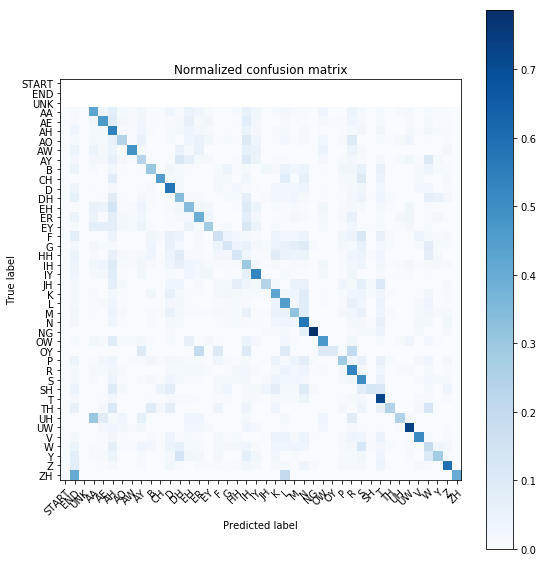

In [75]:
plot_confusion_matrix(cf_mat, phoneme_re_list,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

In [46]:
print(phoneme_re_list)

['START', 'END', 'UNK', 'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW', 'V', 'W', 'Y', 'Z', 'ZH']


In [76]:
print(phoneme_list)

[('AA', 'vowel'), ('AE', 'vowel'), ('AH', 'vowel'), ('AO', 'vowel'), ('AW', 'vowel'), ('AY', 'vowel'), ('B', 'stop'), ('CH', 'affricate'), ('D', 'stop'), ('DH', 'fricative'), ('EH', 'vowel'), ('ER', 'vowel'), ('EY', 'vowel'), ('F', 'fricative'), ('G', 'stop'), ('HH', 'aspirate'), ('IH', 'vowel'), ('IY', 'vowel'), ('JH', 'affricate'), ('K', 'stop'), ('L', 'liquid'), ('M', 'nasal'), ('N', 'nasal'), ('NG', 'nasal'), ('OW', 'vowel'), ('OY', 'vowel'), ('P', 'stop'), ('R', 'liquid'), ('S', 'fricative'), ('SH', 'fricative'), ('T', 'stop'), ('TH', 'fricative'), ('UH', 'vowel'), ('UW', 'vowel'), ('V', 'fricative'), ('W', 'semivowel'), ('Y', 'semivowel'), ('Z', 'fricative'), ('ZH', 'fricative')]


In [81]:
statistics = {'vowel':0, 'fricative':0, 'stop':0, 'affricate':0, 'liquid':0, 'nasal':0, 'semivowel':0, 'aspirate':0}
total = {'vowel':0, 'fricative':0, 'stop':0, 'affricate':0, 'liquid':0, 'nasal':0, 'semivowel':0, 'aspirate':0}
for i in range(39):
    statistics[phoneme_list[i][1]] += cf_mat[i, i]
    total[phoneme_list[i][1]]+= np.sum(cf_mat[i])

In [84]:
keys = total.keys()
res = []
for key in total.keys():
    res.append(float(statistics[key])/float(total[key]))

In [85]:
print(res)

[0.4220314735336195, 0.3653731343283582, 0.2804878048780488, 0.645367412140575, 0.24545454545454545, 0.5238718116415958, 0.5113636363636364, 0.39544159544159546]


<Container object of 8 artists>

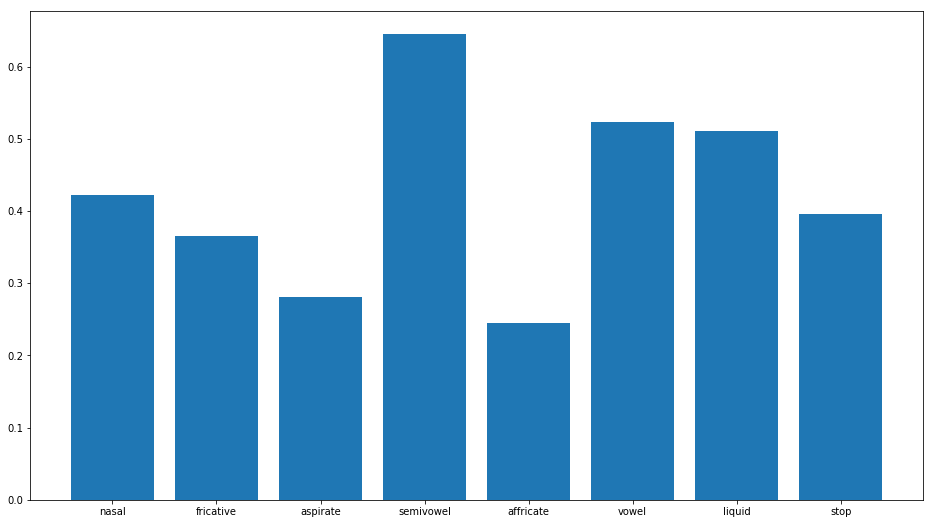

In [88]:
plt.figure(figsize=(16,9))
plt.bar(np.arange(len(keys)), res, tick_label =keys)